In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn

In [2]:
df = pd.read_csv('../data/raw/student_perf.csv')
df = df.sample(frac=0.05).reset_index(drop=True)

In [3]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,4,91,No,7,1,77.0
1,9,55,Yes,7,4,49.0
2,2,52,Yes,4,5,27.0
3,7,65,Yes,6,3,55.0
4,6,54,Yes,8,1,42.0


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for_scaling = ['Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
categorical = ['Extracurricular Activities']

scaled_values = scaler.fit_transform(df[[col for col in df.columns if col in for_scaling]])
df = df.drop(columns=for_scaling)
df = pd.concat([df, pd.DataFrame(scaled_values, columns=for_scaling)], axis=1)

df = pd.get_dummies(df, columns = categorical)
df[['Extracurricular Activities_No', 'Extracurricular Activities_Yes']] =\
  df[['Extracurricular Activities_No', 'Extracurricular Activities_Yes']].astype('int')

In [14]:
df.head()

,Hours Studied,Performance Index,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_No,Extracurricular Activities_Yes
0,5,54.0,0.525424,0.0,0.555556,0,1
1,5,42.0,0.271186,0.2,0.888889,0,1
2,1,68.0,0.864407,1.0,0.000000,1,0
3,3,60.0,0.593220,1.0,0.444444,0,1
4,6,44.0,0.186441,1.0,0.333333,0,1


In [15]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Performance Index'])
y = df[['Performance Index', 'Hours Studied']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# y_train_reshaped = y_train.values.reshape(-1, 1)

In [17]:
from spyct import Model

model = Model(num_trees=1)
model.fit(X_train, y_train.values)

In [18]:
preds = model.predict(X_test.values)

In [19]:
# plt.plot(y_test.values)
# plt.plot(preds)

In [20]:
import sys
sys.path.append('..')

In [21]:
def nanvar_old(y, dim=0):
  mean = torch.nanmean(y, dim)
  squared_diff = (y - mean.unsqueeze(dim)) ** 2
  valid_count = torch.sum(~torch.isnan(y), dim)
  variance = torch.nansum(squared_diff, dim) / (valid_count - 1) 
  return variance

def old_impurity(values): return torch.sum(nanvar_old(values, dim=0))

In [22]:
import torch
def nanvar(tensor, dim=None, keepdim=False):
    tensor_mean = tensor.nanmean(dim=dim, keepdim=True)
    output = (tensor - tensor_mean).square().nanmean(dim=dim, keepdim=keepdim)
    return output

def impurity(tensor, dim=0):
    # Remove nan values along the specified dimension
    valid_values = tensor[~torch.isnan(tensor)]

    # Check if the resulting tensor is empty after removing NaNs
    if valid_values.numel() == 0:
        return float('inf')

    # Compute variance along the specified dimension, ignoring NaNs
    variances = nanvar(tensor, dim=dim)

    # Sum the variances across the specified dimension
    total_variance = torch.sum(variances)

    return total_variance

In [23]:
import torch

def nanvar(tensor, dim=None, keepdim=False):
    tensor_mean = tensor.nanmean(dim=dim, keepdim=True)
    output = (tensor - tensor_mean).square().nanmean(dim=dim, keepdim=keepdim)
    return output

def impurity(tensor, dim=0):
    # Remove nan values along the specified dimension
    valid_values = tensor[~torch.isnan(tensor)]

    # Check if the resulting tensor is empty after removing NaNs
    if valid_values.numel() == 0:
        return float('inf')

    # Compute variance along the specified dimension, ignoring NaNs
    variances = nanvar(tensor, dim=dim)

    # Sum the variances across the specified dimension
    total_variance = torch.sum(variances)

    return total_variance

# Adjusted function to handle multiple target variables
def multi_target_impurity(tensor, target_dim=1):
    """
    Compute impurity for multiple target variables.
    
    tensor: Input tensor where each row represents a sample and each column represents a different target variable.
    target_dim: The dimension along which the targets are stored (e.g., 1 if columns are different targets).
    """
    # Remove NaN values and check for empty tensor
    if tensor.isnan().all():
        return float('inf')
    
    # Compute variances for each target variable (along target_dim)
    variances = nanvar(tensor, dim=0 if target_dim == 1 else 1)
    
    # Return the sum of variances across all target variables
    total_variance = torch.sum(variances)

    return total_variance

In [24]:
y_train_values_tensor = torch.Tensor(y_train.values)

In [25]:
new_impurity = multi_target_impurity(y_train_values_tensor)

In [26]:
new_impurity

tensor(366.1135)

In [27]:
import torch
import pyro
import numpy as np
from pyro.infer import Predictive
import random

def load_and_prediction(model, guide, x_test, num_samples = 1, device = 'cpu'):
    pyro.clear_param_store()
    predictive = Predictive(model = model.to(device),
                            guide=guide,
                            num_samples=num_samples,
                            return_sites=("linear.weight", "linear.bias"))
    data = predictive(x_test.clone().detach())#, None,x.shape[0])
    return data

class VNode:
    def __init__(self, depth=0, num_instances=0, root=False):
        self.left = None
        self.right = None
        self.prototype = None   
        self.split_model = None
        self.guide = None
        self.order = None
        self.depth = depth
        self.is_root = root
        self.param_store = None
        self.losses = None
        self.num_instances = num_instances

    def is_leaf(self): return self.left is None and self.right is None

    def predict(self, x):
        if self.is_leaf():
            return self.prototype
        else:
            data = load_and_prediction(self.split_model, self.guide, x)
            splits = (data['linear.weight'] @ x + data['linear.bias']).sigmoid()
            splits = splits.reshape(-1)
            if splits.shape[0]>1:
                return torch.stack([self.left.predict(x) if split<=0.5 else self.right.predict(x) for split in splits])
            else:
                if splits <= 0.5: return self.left.predict(x)
                else: return self.right.predict(x)

    def mc_predict(self, x, num_samples=20):
        pred_lst = []
        for i in range(num_samples):
            pred_lst.append(self.predict(x))
        return torch.stack(pred_lst)
    


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from tqdm import trange
import pyro
import pyro.distributions as dist
import pyro.optim
import pyro.infer
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide.guides import AutoDiagonalNormal
from pyro import infer
import pyro.distributions as dist

# def weighted_variance(values, weights, weight_sum):
#     mean = torch.matmul(weights, values) / weight_sum
#     return -torch.sum(mean*mean)


def weighted_variance(values, weights, weight_sum):
    mean = torch.matmul(weights, values) / weight_sum
    squared_diff = (values - mean) ** 2
    weighted_var = torch.sum(torch.matmul(weights, squared_diff)) / weight_sum
    return weighted_var


class Impurity(PyroModule):
    def __init__(self, input_dim, output_dim, device='cpu'):
        super(Impurity, self).__init__()
        self.device = device
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = PyroModule[nn.Linear](self.input_dim, self.output_dim)

        self.linear.weight = PyroSample(dist.Normal(0, 1).expand([self.output_dim, self.input_dim]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0, 1).expand([self.output_dim]).to_event(1))

    def forward(self, descriptive_data, clustering_data):
        # sigma = pyro.sample("sigma", dist.Normal(0., 1.))
        right_selection = self.linear(descriptive_data).reshape(-1).sigmoid()
        left_selection = torch.tensor(1., device=self.device) - right_selection
        

        right_weight_sum = torch.sum(right_selection)
        left_weight_sum = torch.sum(left_selection)
        

        var_left = weighted_variance(clustering_data, left_selection, left_weight_sum)
        var_right = weighted_variance(clustering_data, right_selection, right_weight_sum)
        
        impurity = (left_weight_sum * var_left + right_weight_sum * var_right) + torch.norm(self.linear.weight, p=0.5)

        
        try:
            with pyro.plate("data", descriptive_data.shape[0]):
                obs = pyro.sample("obs", dist.Normal(impurity, 1.0), obs=torch.tensor(0.))#torch.tensor(0.))
        except: print('NAN!')
        
        
        return impurity
    
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def is_converged(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop
  

def learn_split_vb(rows, descriptive_data, clustering_data, device, epochs, bs, lr, subspace_size, patience=5, enable_validation=False):
    pyro.enable_validation(enable_validation)
    selected_attributes = np.random.choice(a=[False, True],
                                            size=descriptive_data.size(1),
                                            p=[1-subspace_size, subspace_size])
    descriptive_subset = descriptive_data[:, selected_attributes]

    pyro.clear_param_store()
    model = Impurity(input_dim=descriptive_subset.size(1), output_dim=1).to(device)
    guide = AutoDiagonalNormal(model)
    # adam_params = {"lr": lr }#, "betas": (0.90, 0.999)}
    optimizer = torch.optim.Adam
    scheduler = pyro.optim.LinearLR({'optimizer': optimizer, 'optim_args': {'lr': lr}})

    early_stopping = EarlyStopping(patience=patience, min_delta=0.1)

    # Setup SVI
    svi = infer.SVI(model,
                    guide,
                    scheduler,
                    loss=infer.TraceMeanField_ELBO(num_particles=5))
    losses = []
    # _steps = 0
    if bs is None: bs = rows.size(0)
    num_batches = math.ceil(rows.size(0) / bs)
    for epoch in trange(epochs, desc="Epochs"):
        train_loss = 0.0
        for b in range(num_batches):
            descr = descriptive_subset[b*bs:(b+1)*bs]
            clustr = clustering_data[b*bs:(b+1)*bs]
            train_loss += svi.step(descr, clustr)
            # if _steps<1:
            #     param_store = pyro.get_param_store()['AutoDiagonalNormal.loc']
            # _steps+=1
        if early_stopping.is_converged(train_loss):
              print(f"Early stopping at epoch {epoch}.")
              break
        losses.append(train_loss)
        scheduler.step()
        # print("[iteration %04d] loss: %.4f" % (epoch+1, train_loss))
    print(model)
    return (model, guide, losses)

In [73]:
descriptive_data = torch.Tensor(X_train.values)
clustering_data = y_train_values_tensor
model = Impurity(input_dim=descriptive_data.size(1), output_dim=1).to('cpu')
model(descriptive_data[1:10], clustering_data[1:10])

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [74]:
from scipy.io import arff
import pandas as pd

atp_train = pd.DataFrame(arff.loadarff('../data/raw/atp1d-train.arff')[0])
atp_test = pd.DataFrame(arff.loadarff('../data/raw/atp1d-test.arff')[0])

atp_train = atp_train.dropna()
atp_test = atp_test.dropna()

target_colz = [col for col in atp_train.columns if col.startswith('LBL')]

x_atp_train = atp_train.drop(columns=target_colz).values
y_atp_train = atp_train[target_colz].values

x_atp_test = atp_test.drop(columns=target_colz).values
y_atp_test = atp_test[target_colz].values

In [75]:
from scipy.io import arff
import pandas as pd

df = pd.DataFrame(arff.loadarff('../data/raw/cpu_small.arff')[0])

target_col =  df.columns[-1]
non_target_columns = df.columns[df.columns!=target_col]

df[non_target_columns] = df[non_target_columns].apply(lambda x: x.fillna(x.mean()), axis=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for_scaling = df.columns[df.columns!=target_col].tolist()

scaled_values = scaler.fit_transform(df[[col for col in df.columns if col in for_scaling]])
df = df.drop(columns=for_scaling)
df = pd.concat([df, pd.DataFrame(scaled_values, columns=for_scaling)], axis=1)

X = df.drop(columns=target_col).values
y = df[target_col].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [76]:
descriptive_data = torch.Tensor(X_train)
clustering_data = torch.Tensor(y_train)

In [77]:
torch.cat((descriptive_data, clustering_data.reshape(-1,1)), dim=1)[0]

tensor([3.2520e-03, 3.4783e-03, 2.6542e-01, 3.8780e-02, 2.5142e-02, 2.9821e-02,
        3.6938e-02, 7.7626e-02, 5.0455e-02, 1.0631e-03, 1.5194e-01, 6.8358e-01,
        8.9000e+01])

In [78]:
descriptive_data.shape, clustering_data.shape

(torch.Size([6553, 12]), torch.Size([6553]))

In [83]:
y_train.tolist()

[89.0,
 88.0,
 86.0,
 94.0,
 88.0,
 85.0,
 94.0,
 80.0,
 92.0,
 97.0,
 86.0,
 74.0,
 0.0,
 70.0,
 69.0,
 88.0,
 98.0,
 94.0,
 95.0,
 96.0,
 88.0,
 83.0,
 77.0,
 96.0,
 90.0,
 81.0,
 97.0,
 72.0,
 69.0,
 93.0,
 93.0,
 88.0,
 98.0,
 91.0,
 85.0,
 85.0,
 81.0,
 91.0,
 91.0,
 66.0,
 85.0,
 82.0,
 72.0,
 89.0,
 0.0,
 91.0,
 97.0,
 88.0,
 89.0,
 94.0,
 92.0,
 88.0,
 84.0,
 91.0,
 76.0,
 80.0,
 88.0,
 0.0,
 93.0,
 87.0,
 83.0,
 89.0,
 92.0,
 89.0,
 89.0,
 83.0,
 80.0,
 87.0,
 90.0,
 90.0,
 94.0,
 76.0,
 98.0,
 97.0,
 82.0,
 90.0,
 90.0,
 95.0,
 64.0,
 97.0,
 98.0,
 84.0,
 71.0,
 83.0,
 96.0,
 94.0,
 91.0,
 87.0,
 92.0,
 93.0,
 84.0,
 88.0,
 86.0,
 97.0,
 90.0,
 97.0,
 89.0,
 95.0,
 63.0,
 90.0,
 83.0,
 67.0,
 84.0,
 95.0,
 92.0,
 98.0,
 88.0,
 92.0,
 87.0,
 88.0,
 88.0,
 91.0,
 87.0,
 89.0,
 57.0,
 93.0,
 96.0,
 97.0,
 82.0,
 90.0,
 99.0,
 68.0,
 91.0,
 92.0,
 85.0,
 90.0,
 79.0,
 96.0,
 80.0,
 83.0,
 70.0,
 88.0,
 69.0,
 0.0,
 94.0,
 90.0,
 88.0,
 93.0,
 87.0,
 92.0,
 92.0,
 88.0,
 91.0,
 90

In [81]:
max_depth = 5
minimum_examples_to_split = 2
epochs = 500
bs = 32
lr = 0.01
subspace_size = 1
device = 'cpu'
root_node = VNode(depth=0, root = True)
rows = torch.arange(X_train.shape[0])
total_variance = impurity(torch.Tensor(y_train))
descriptive_data = torch.Tensor(X_train)
clustering_data = torch.Tensor(y_train)
# clustering_data = torch.cat((descriptive_data, clustering_data.reshape(-1,1)), dim=1)
splitting_queue = [(root_node, rows, total_variance)]

new_impurity = impurity(torch.Tensor(y_train))
print(new_impurity)

root_node.num_instances = rows.shape[0]
order = 0

while splitting_queue:
    node, rows, total_variance = splitting_queue.pop()
    node.order = order
    node.num_instances = rows.shape[0]
    order += 1
    if total_variance > 0 and node.depth < max_depth and rows.size(0) >= minimum_examples_to_split:

        split_model, guide, losses = learn_split_vb(
            rows, descriptive_data[rows], clustering_data[rows],
            device=device, epochs=epochs, bs=bs, lr=lr, subspace_size=subspace_size)
        
        predictive = Predictive(model = split_model.linear.to(device),
                    guide=guide,
                    num_samples=50,
                    return_sites=("linear.weight", "linear.bias"))
        sdata = predictive(descriptive_data[rows].clone().detach())
        sdata_lin = torch.mean(sdata['linear.weight'], dim=0).reshape(-1, 1).T.T
        sdata_b = torch.mean(sdata['linear.bias'], dim=0).reshape(-1, 1).T
        ssplit = (descriptive_data[rows] @ sdata_lin + sdata_b).sigmoid()
        split = ssplit.reshape(-1)
        # print(split.numpy().tolist())

        # split_model = split_model.linear
        # split = split_model(descriptive_data[rows]).squeeze()
        
        rows_right = rows[split > torch.tensor(0.5, device=device)]
        var_right = impurity(clustering_data[rows_right])
        rows_left = rows[split <= torch.tensor(0.5, device=device)]
        var_left = impurity(clustering_data[rows_left])

        print('Rows left: ', rows_left.shape, 'Var left', var_left)
        print('Rows right: ', rows_right.shape, 'Var right', var_right)

        if (var_left < total_variance or var_right < total_variance) and (minimum_examples_to_split < rows_right.shape[0] and minimum_examples_to_split < rows_left.shape[0]):
            node.split_model = split_model.linear
            node.guide = guide
            node.losses = losses
            node.left = VNode(depth=node.depth+1)
            node.right = VNode(depth=node.depth+1)
            splitting_queue.append((node.left, rows_left, var_left, ))
            splitting_queue.append((node.right, rows_right, var_right, ))
        # potentially to be fixed
        else:
            if len(clustering_data.shape)==1: node.prototype = torch.nanmean(clustering_data[rows], dim=0)
            else:
                # node.prototype = torch.nanmean(clustering_data[rows], dim=0)
                clustering_data_np = clustering_data.numpy()
                prototype = []
                for col in range(clustering_data_np.shape[1]):
                    non_nan_values = clustering_data_np[rows, col][~torch.isnan(clustering_data[rows, col])]
                    mean_value = np.nanmean(non_nan_values)
                    prototype.append(mean_value)
                node.prototype = torch.tensor(np.array(prototype))
    else:
        # node.prototype = torch.nanmean(clustering_data[rows], dim=0)
        if len(clustering_data.shape)==1: node.prototype = torch.nanmean(clustering_data[rows], dim=0)
        else:
            clustering_data_np = clustering_data.numpy()
            prototype = []
            for col in range(clustering_data_np.shape[1]):
                non_nan_values = clustering_data_np[rows, col][~torch.isnan(clustering_data[rows, col])]
                mean_value = np.nanmean(non_nan_values)
                prototype.append(mean_value)
            node.prototype = torch.tensor(np.array(prototype))

tensor(348.1495)


Epochs:  15%|█▌        | 76/500 [01:05<06:06,  1.16it/s]


Early stopping at epoch 76.
Impurity(
  (linear): PyroLinear(in_features=12, out_features=1, bias=True)
)
Rows left:  torch.Size([6309]) Var left tensor(80.0452)
Rows right:  torch.Size([244]) Var right tensor(0.1536)


Epochs:  10%|█         | 52/500 [00:01<00:15, 29.68it/s]


Early stopping at epoch 52.
Impurity(
  (linear): PyroLinear(in_features=12, out_features=1, bias=True)
)
Rows left:  torch.Size([0]) Var left inf
Rows right:  torch.Size([244]) Var right tensor(0.1536)


Epochs:   3%|▎         | 14/500 [00:12<07:05,  1.14it/s]


KeyboardInterrupt: 

In [204]:
def predict(root_node, descriptive_data):
  raw_predictions = [root_node.mc_predict(descriptive_data[i]) for i in range(descriptive_data.size(0))]
  return torch.stack(raw_predictions)

In [205]:
preds = predict(root_node, torch.Tensor(X_test.values))

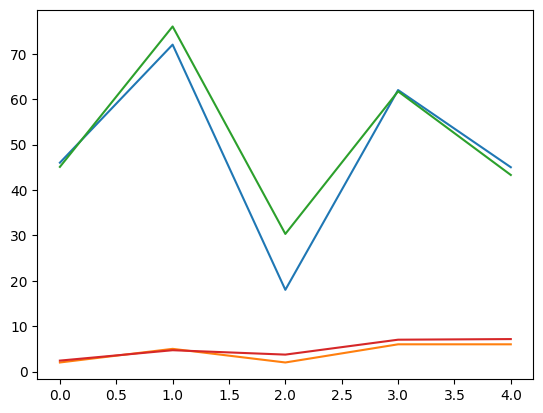

In [206]:
plt.plot(y_test.values[20:25])
plt.plot(preds.mean(axis=1)[20:25])

In [207]:
# from src.models.model import VSpyct

# model = VSpyct()
# model.fit(torch.Tensor(X_train.values), torch.Tensor(y_train.values))

In [208]:
preds_mean = preds.mean(axis=1)
preds_mean

tensor([[25.4815,  1.5926],
        [43.2949,  7.1538],
        [65.3871,  2.1452],
        [81.8857,  7.8000],
        [80.0057,  6.9600],
        [30.3111,  3.7333],
        [43.2949,  7.1538],
        [30.3111,  3.7333],
        [61.7119,  7.0169],
        [81.8857,  7.8000],
        [43.2949,  7.1538],
        [68.1497,  3.0361],
        [43.2949,  7.1538],
        [69.6323,  3.1671],
        [30.3111,  3.7333],
        [65.3871,  2.1452],
        [43.2949,  7.1538],
        [61.7119,  7.0169],
        [62.0794,  6.5298],
        [61.7119,  7.0169],
        [45.0767,  2.4111],
        [76.0000,  4.7000],
        [30.3111,  3.7333],
        [61.7119,  7.0169],
        [43.2949,  7.1538],
        [79.2000,  6.6000],
        [61.7119,  7.0169],
        [61.7119,  7.0169],
        [43.2949,  7.1538],
        [77.5486,  5.5800],
        [43.2949,  7.1538],
        [25.6250,  1.0000],
        [43.2949,  7.1538],
        [65.3871,  2.1452],
        [43.7778,  2.8519],
        [79.2000,  6

In [209]:
y_test.values

array([[33.,  2.],
       [35.,  7.],
       [59.,  1.],
       [85.,  7.],
       [89.,  9.],
       [36.,  2.],
       [46.,  8.],
       [31.,  6.],
       [64.,  6.],
       [84.,  7.],
       [41.,  6.],
       [73.,  4.],
       [45.,  5.],
       [77.,  4.],
       [35.,  4.],
       [74.,  3.],
       [51.,  7.],
       [67.,  6.],
       [65.,  4.],
       [60.,  9.],
       [46.,  2.],
       [72.,  5.],
       [18.,  2.],
       [62.,  6.],
       [45.,  6.],
       [76.,  7.],
       [59.,  8.],
       [53.,  5.],
       [52.,  9.],
       [86.,  6.],
       [44.,  7.],
       [14.,  1.],
       [49.,  8.],
       [58.,  1.],
       [46.,  4.],
       [78.,  7.],
       [46.,  3.],
       [44.,  6.],
       [32.,  4.],
       [69.,  9.],
       [82.,  8.],
       [62.,  2.],
       [72.,  2.],
       [55.,  4.],
       [32.,  6.],
       [67.,  3.],
       [49.,  2.],
       [50.,  3.],
       [55.,  9.],
       [39.,  5.],
       [20.,  4.],
       [32.,  4.],
       [60.,

In [210]:
from spyct import Model

model = Model(num_trees=1)
model.fit(X_train, y_train.values)

In [211]:
preds_spyct_orig = model.predict(X_test.values)
preds_spyct_orig

array([[39.75     ,  2.       ],
       [32.857143 ,  7.       ],
       [59.       ,  1.       ],
       [89.       ,  7.       ],
       [85.       ,  9.       ],
       [39.75     ,  2.       ],
       [53.       ,  8.       ],
       [31.       ,  5.       ],
       [58.       ,  6.       ],
       [89.       ,  7.       ],
       [47.384613 ,  6.538461 ],
       [72.       ,  4.       ],
       [40.       ,  5.       ],
       [69.       ,  4.       ],
       [33.       ,  4.       ],
       [65.       ,  3.       ],
       [54.       ,  7.       ],
       [59.       ,  6.       ],
       [63.333332 ,  4.       ],
       [58.       ,  9.       ],
       [46.       ,  2.       ],
       [72.       ,  5.       ],
       [19.       ,  2.       ],
       [63.       ,  6.       ],
       [47.384613 ,  6.538461 ],
       [82.       ,  7.       ],
       [62.666668 ,  7.3333335],
       [54.       ,  5.       ],
       [56.       ,  9.       ],
       [83.4      ,  6.       ],
       [47

In [212]:
y_test.values

array([[33.,  2.],
       [35.,  7.],
       [59.,  1.],
       [85.,  7.],
       [89.,  9.],
       [36.,  2.],
       [46.,  8.],
       [31.,  6.],
       [64.,  6.],
       [84.,  7.],
       [41.,  6.],
       [73.,  4.],
       [45.,  5.],
       [77.,  4.],
       [35.,  4.],
       [74.,  3.],
       [51.,  7.],
       [67.,  6.],
       [65.,  4.],
       [60.,  9.],
       [46.,  2.],
       [72.,  5.],
       [18.,  2.],
       [62.,  6.],
       [45.,  6.],
       [76.,  7.],
       [59.,  8.],
       [53.,  5.],
       [52.,  9.],
       [86.,  6.],
       [44.,  7.],
       [14.,  1.],
       [49.,  8.],
       [58.,  1.],
       [46.,  4.],
       [78.,  7.],
       [46.,  3.],
       [44.,  6.],
       [32.,  4.],
       [69.,  9.],
       [82.,  8.],
       [62.,  2.],
       [72.,  2.],
       [55.,  4.],
       [32.,  6.],
       [67.,  3.],
       [49.,  2.],
       [50.,  3.],
       [55.,  9.],
       [39.,  5.],
       [20.,  4.],
       [32.,  4.],
       [60.,

In [230]:
i = 59
preds[i], y_test.values[i], preds[i].mean(axis=0)

(tensor([[79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000],
         [79.2000,  6.6000]]),
 array([75.,  6.]),
 tensor([79.2000,  6.6000]))

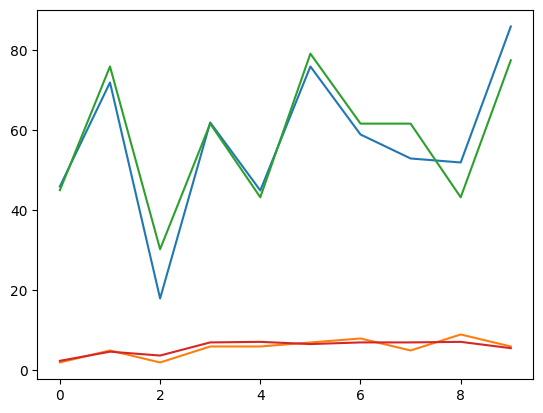

In [216]:
plt.plot(y_test.values[20:30])
# plt.plot(preds_spyct_orig[20:30])
plt.plot(preds_mean[20:30])

In [127]:
i = 12

In [128]:
preds[i]

tensor([[42.9506,  7.1111],
        [42.9506,  7.1111],
        [44.8333,  2.8667],
        [42.9506,  7.1111],
        [44.8333,  2.8667],
        [44.8333,  2.8667],
        [42.9506,  7.1111],
        [42.9506,  7.1111],
        [42.9506,  7.1111],
        [44.8333,  2.8667]])

In [129]:
preds[i].min(), preds[i].max()

(tensor(2.8667), tensor(44.8333))

In [130]:
y_test.values[i]

array([45.,  5.])

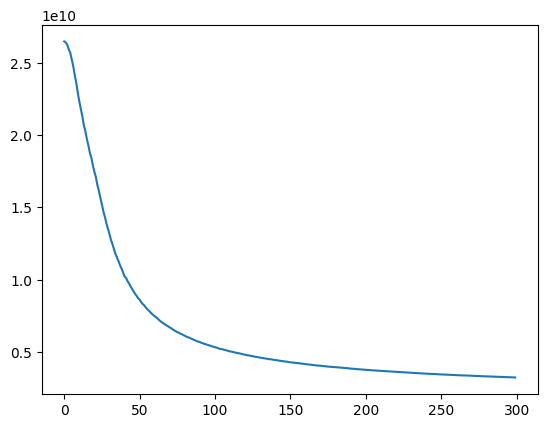

In [131]:
plt.plot(root_node.losses)